# 1. Remarks
1.  Split dataset int train & test sets

2.  Do 4-fold cross validation.
    - Split train set into training & validation sets by 4-fold (i.e., 3 training parts + 1 validation part)
    - Train the models
    - We obtain 4 different trained models 
    - Evaluate those 4 trained models using test set
    
    
3.  Because using 4-fold cross validation, we need to do the feature extraction separately for each fold

    The reason is that we must standardize / normalize the feature (for training & validation sets) before fitting into the model
    
4.  Step-by-step doing feature extraction for each fold 
    * From the training set, we do:
        - SIFT + bags of visual words (i.e., k-means clustering) 
        - Gabor 
        - HOG + PCA 
        - LBP histogram + PCA
    *  Standardize the features for training set
    *  Fit obtained standardization into validation set and also test set 


In [29]:
import os

import pandas as pd

import numpy as np
from numpy import random

from random import sample

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import skimage
from skimage import io
from skimage.feature import daisy, hog, ORB, local_binary_pattern, SIFT
from skimage.color import label2rgb, rgb2gray
from skimage.transform import resize, rotate, downscale_local_mean


from skimage.util import img_as_float
from skimage.filters import threshold_niblack
from skimage.morphology import convex_hull_image
from skimage.measure import find_contours
from skimage import exposure

import sklearn
from sklearn.cluster import MiniBatchKMeans
from sklearn.decomposition import PCA
from sklearn import preprocessing
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from scipy import ndimage as ndi

from tqdm.notebook import tqdm

from more_itertools import chunked
# from tqdm import tqdm

import gc

from joblib import Parallel, delayed

In [2]:
from platform import python_version

print(python_version())

3.9.16


In [3]:
print(skimage.__version__)

0.19.3


In [30]:
sklearn.show_versions()


System:
    python: 3.9.16 (main, Mar  8 2023, 10:39:24) [MSC v.1916 64 bit (AMD64)]
executable: c:\Users\ldqth\anaconda3\envs\image_processing\python.exe
   machine: Windows-10-10.0.22621-SP0

Python dependencies:
      sklearn: 1.2.2
          pip: 23.0.1
   setuptools: 65.6.3
        numpy: 1.23.5
        scipy: 1.10.0
       Cython: 0.29.34
       pandas: 1.5.3
   matplotlib: 3.7.1
       joblib: 1.1.1
threadpoolctl: 2.2.0

Built with OpenMP: True

threadpoolctl info:
       filepath: C:\Users\ldqth\anaconda3\envs\image_processing\Library\bin\mkl_rt.1.dll
         prefix: mkl_rt
       user_api: blas
   internal_api: mkl
        version: 2021.4-Product
    num_threads: 6
threading_layer: intel

       filepath: C:\Users\ldqth\anaconda3\envs\image_processing\Library\bin\libiomp5md.dll
         prefix: libiomp
       user_api: openmp
   internal_api: openmp
        version: None
    num_threads: 12

       filepath: C:\Users\ldqth\anaconda3\envs\image_processing\vcomp140.dll
       

## 3.1. An example of extracting SIFT

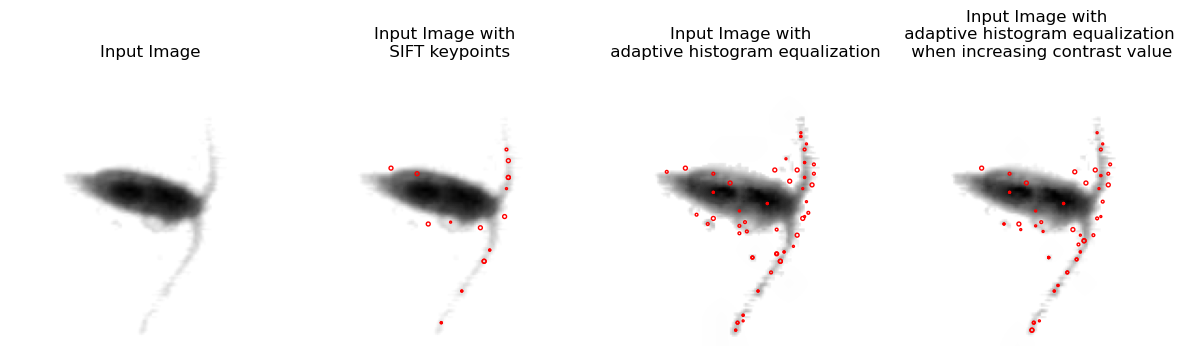

In [4]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
# Load the grayscale image
image = io.imread(dfFoldTraining_1["filenames"][12345], as_gray=True)

# Perform histogram equalization
image_eq = exposure.equalize_adapthist(image, clip_limit=0.1)

descriptor_extractor = SIFT()

descriptor_extractor.detect_and_extract(image)

descriptor_extractor2 = SIFT()

descriptor_extractor2.detect_and_extract(image_eq)

# Perform histogram equalization
image_adeq = exposure.equalize_adapthist(image, clip_limit=0.03)
descriptor_extractor3 = SIFT()

descriptor_extractor3.detect_and_extract(image_adeq)


fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12, 6))


ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].set_title("Input Image")

ax[1].imshow(image, cmap=plt.cm.gray)
ax[1].scatter(descriptor_extractor.keypoints[:, 1], descriptor_extractor.keypoints[:, 0],
              2 ** descriptor_extractor.scales, facecolors='none', edgecolors='r')
ax[1].set_title('Input Image with \n SIFT keypoints')


ax[2].imshow(image_eq, cmap=plt.cm.gray)
ax[2].set_title("Input Image with \n adaptive histogram equalization")
ax[2].scatter(descriptor_extractor2.keypoints[:, 1], descriptor_extractor2.keypoints[:, 0],
              2 ** descriptor_extractor2.scales, facecolors='none', edgecolors='r')

ax[3].imshow(image_adeq, cmap=plt.cm.gray)
ax[3].set_title("Input Image with \n adaptive histogram equalization \n when increasing contrast value")
ax[3].scatter(descriptor_extractor3.keypoints[:, 1], descriptor_extractor3.keypoints[:, 0],
              2 ** descriptor_extractor3.scales, facecolors='none', edgecolors='r')

for a in ax:
    a.axis('off')

plt.tight_layout()
plt.show()


# 4. Extract SIFT + kmeans features

<u><b>Remarks:</b></u>
1. Read training-validation sets of a fold and test set
2. For training set:
    1. Extract SIFT features: SIFT_list (num_of_images, num_of_SIFT_feature)
    2. Standard deviation normalization the HOG_list. Let's say Std_scaler()
    3. Using MinibatchKmeans, analyze how many k to use by elbow's anlysis or silouette analysis
3. For validation set:
    1. Extract HOG features
    2. Using previous Std_scaler(), which perform on the training set, to normalize the HOG features
    3. Apply MinibatchKmeans for clustering
4. For test set:
    1. We do the same
    2. Just be careful about the filename. Because we have only 1 test set. e.g., we could have test_SIFT_fold_1, test_SIFT_fold_2,...
    

## 4.1. Core functions

In [5]:
def image_generator(filepaths):
    for filepath in filepaths:
        yield io.imread(filepath, as_gray=True)

In [6]:
def crop_image(image):
    img_height = image.shape[0]
    if img_height < 2000:
        return image
    
    # adaptive thresholding
    thresh_niblack = threshold_niblack(image, window_size=25, k=0.8)
    binary_niblack = image > thresh_niblack

    # make convex hull
    chull = convex_hull_image(np.pad(binary_niblack, 3, 'constant', constant_values=0))
    
    # Find the contours of the main object
    contours = find_contours(chull, 0.5)

    # Find the largest contour (assumed to be the main object)
    largest_contour = max(contours, key=len)

    # Compute the bounding box coordinates for the largest contour
    min_row, min_col = np.min(largest_contour, axis=0)
    max_row, max_col = np.max(largest_contour, axis=0)

    # Compute the optimal cropping dimensions based on the bounding box
    padding = 10  # Adjust the padding as desired
    crop_min_row = int(max(min_row - padding, 0))
    crop_min_col = int(max(min_col - padding, 0))
    crop_max_row = int(min(max_row + padding, image.shape[0]))
    crop_max_col = int(min(max_col + padding, image.shape[1]))

    # Crop the image using the computed dimensions
    cropped_image = image[crop_min_row:crop_max_row, crop_min_col:crop_max_col]

    return cropped_image

In [7]:
def extract_SIFT_feature (image): 

    image = crop_image(image) 

    # Adaptive Equalization
    image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.03)
    
    # Initialize the SIFT feature extractor
    sift = SIFT()
    
    try:
        # Detect keypoints and compute descriptors
        sift.detect_and_extract(image_adapteq)
    except: #in case of failure
        image_adapteq = exposure.equalize_adapthist(image, clip_limit=0.1)
        sift.detect_and_extract(image_adapteq)
    
    return sift.descriptors

## 4.2. main()

### 4.2.1. For fold 1
#### 1. Read path of fold 1 file

In [8]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_1.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_1.csv')

#### 2. Extracting SIFT feature for the training set

In [9]:
filepaths = dfFoldTraining_1['filenames']

n_files = len(filepaths)

batch_size = 512

num_processes = 12

SIFT_descriptor_train_list = []

# Extract SIFT features for all images in parallel
with tqdm(total=n_files, desc="Extract SIFT descriptors") as pbar:

    with Parallel(n_jobs=num_processes) as parallel:

        for batch in chunked(image_generator(filepaths), batch_size):

            batch_results = parallel(
                delayed(extract_SIFT_feature)(img) for img in batch)

            # Process the results and store descriptors
            for descriptors in batch_results:
                SIFT_descriptor_train_list.append(descriptors)
            
            del batch_results
            gc.collect()

            pbar.update(len(batch))

# Convert the descriptors list to a numpy array
SIFT_descriptor_train_array = np.concatenate(SIFT_descriptor_train_list)

Extract SIFT descriptors:   0%|          | 0/44099 [00:00<?, ?it/s]

In [10]:
SIFT_descriptor_train_array.shape

(5088881, 128)

In [11]:
# Perform standardization on the descriptors
train_scaler = StandardScaler().fit(SIFT_descriptor_train_array)

train_descriptors_std = train_scaler.transform(SIFT_descriptor_train_array)

In [12]:
display(train_descriptors_std)

array([[ 2.89660017,  0.24117538, -0.42047888, ..., -0.43701754,
        -0.50511648, -0.370238  ],
       [ 1.11855497,  3.85476132,  3.90873769, ..., -0.43701754,
        -0.50511648, -0.67568002],
       [-0.73793339, -0.53822551, -0.46210596, ...,  3.04174348,
         3.66513799,  0.60717646],
       ...,
       [-0.1888312 , -0.53822551, -0.46210596, ..., -0.23708875,
         0.54620818, -0.2786054 ],
       [-0.73793339, -0.53822551, -0.46210596, ..., -0.43701754,
        -0.47007232,  0.27119024],
       [-0.68563794, -0.53822551, -0.46210596, ..., -0.43701754,
        -0.50511648, -0.67568002]])

In [13]:
print('Total SIFT features:',(train_descriptors_std.shape))

Total SIFT features: (5088881, 128)


In [14]:
type(train_descriptors_std)

numpy.ndarray

In [15]:
%store train_descriptors_std

OverflowError: serializing a string larger than 4 GiB requires pickle protocol 4 or higher

In [9]:
import pickle

In [16]:
with open("..//_inputs//_image_features//new//SIFT_descriptors_train_list.pkl", "wb") as f:
    pickle.dump(train_descriptors_std, f)

In [10]:
# load SIFT descripors
with open("..//_inputs//_image_features//new//SIFT_descriptors_train_list.pkl", "rb") as f:
    train_descriptors_std = pickle.load(f)

#### 3. Kmean clustering on the SIFT features of training set  

##### 3.1. Elbow Method 
To determine the appropriate number of clusters using the within-cluster sum of squares (WCSS)


The elbow method involves plotting the within-cluster sum of squares (WCSS) against the number of clusters. 

The WCSS measures the compactness of the clusters. As the number of clusters increases, the WCSS tends to decrease. 

However, there is a point where the improvement in WCSS becomes marginal, resulting in an elbow-like shape in the plot. 

The number of clusters at the elbow point can be considered a reasonable choice.



In [102]:
def compute_wcss(num_clusters, train_descriptors_list):
    
    batch_size = 4096
    # kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, n_init="auto") # if using newest verion
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size) # if using older verion

    kmeans.fit(train_descriptors_list)

    return kmeans.inertia_

In [103]:
max_clusters = 1024  # Maximum number of clusters
batch_size = max_clusters*10  # Batch size for partial_fit

# Split the descriptors into batches 
n_samples = train_descriptors_std.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

num_processes = 16

# Perform MiniBatchKMeans clustering on the descriptors
# wcss = []  # Within-cluster sum of squares

with Parallel(n_jobs=num_processes) as parallel:
    wcss = parallel(
                delayed(compute_wcss)(num_clusters, train_descriptors_std) 
                for num_clusters in tqdm(range(8, max_clusters+1, 8), desc="Analyzing number of clusters")
                )

Analyzing number of clusters:   0%|          | 0/128 [00:00<?, ?it/s]

In [107]:
index_list = range(8, 1024+1, 8)

display(len(index_list))

128

In [108]:
list_i = []
for i in range(1, 128+1, 8):
    list_i.append(i)
    
print(list_i)

[1, 9, 17, 25, 33, 41, 49, 57, 65, 73, 81, 89, 97, 105, 113, 121]


In [109]:
[index_list[i-1] for i in list_i]

[8, 72, 136, 200, 264, 328, 392, 456, 520, 584, 648, 712, 776, 840, 904, 968]

In [110]:
[wcss[i-1] for i in list_i]

[508338005.19811857,
 371446617.767989,
 343784596.8989574,
 328635651.02140343,
 318539204.2375316,
 310206849.3465861,
 304420885.0639298,
 299165875.2022884,
 294886455.00845206,
 291242552.38105094,
 287991915.17790496,
 284823980.14283526,
 282253650.655632,
 279999622.67940754,
 277826155.03407633,
 275793000.9783362]

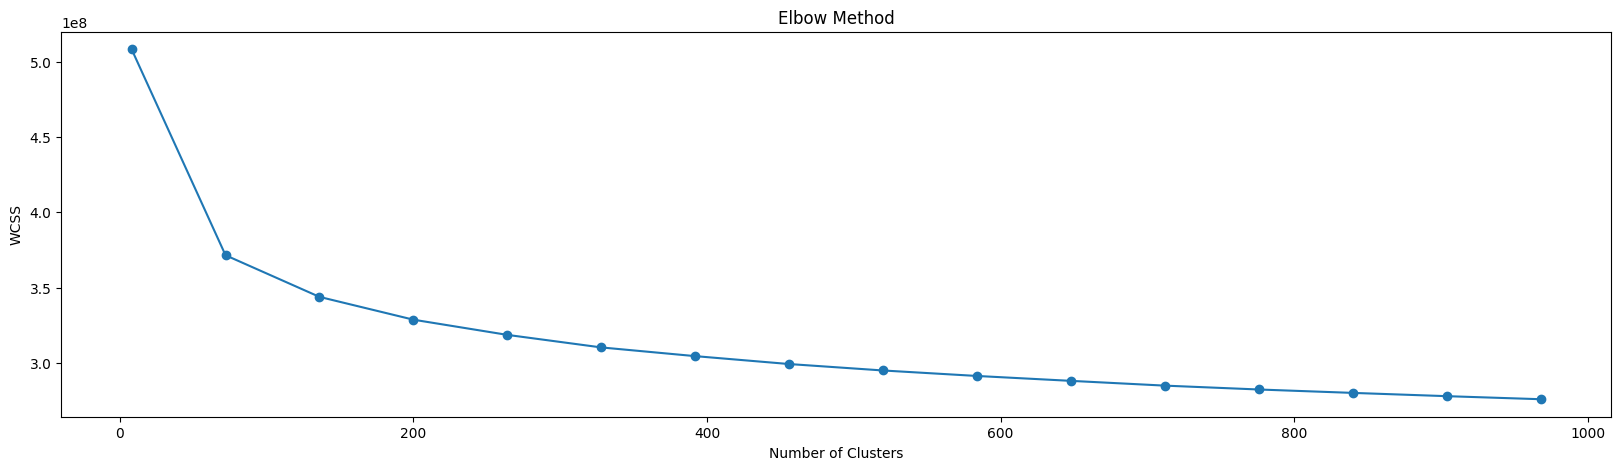

In [111]:
# Plot the WCSS values against the number of clusters
plt.figure(figsize=(20,5))
plt.scatter([index_list[i-1] for i in list_i], [wcss[i-1] for i in list_i])
plt.plot([index_list[i-1] for i in list_i], [wcss[i-1] for i in list_i])
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method')
plt.show()

##### 3.1. Silhouette Scores
The silhouette score measures the quality of clustering by considering both the compactness of the clusters and the separation between them. 

It ranges from -1 to 1, where a higher value indicates better-defined clusters.

 You can calculate the silhouette score for different numbers of clusters and choose the number that maximizes the score.

In [11]:
from sklearn.metrics import silhouette_score

In [18]:
def compute_silhouette_score(num_clusters, train_descriptors_list):
    batch_size=4096
    # kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size, n_init="auto") # if using newest verion
    kmeans = MiniBatchKMeans(n_clusters=num_clusters, random_state=0, batch_size=batch_size) # if using older verion

    kmeans.fit(train_descriptors_list)

    silhouette_avg = silhouette_score(train_descriptors_list, kmeans.labels_)

    return silhouette_avg

In [19]:
max_clusters = 1024  # Maximum number of clusters
batch_size = max_clusters*10  # Batch size for partial_fit

# Split the descriptors into batches 
n_samples = train_descriptors_std.shape[0]
n_batches = int(np.ceil(n_samples / batch_size))

num_processes = 12

# Perform MiniBatchKMeans clustering on the descriptors
# wcss = []  # Within-cluster sum of squares

with Parallel(n_jobs=num_processes) as parallel:
    wcss = parallel(
                delayed(compute_silhouette_score)(num_clusters, train_descriptors_std) 
                for num_clusters in tqdm(range(8, max_clusters+1, 8), desc="Analyzing number of clusters")
                )

Analyzing number of clusters:   0%|          | 0/128 [00:00<?, ?it/s]

In [31]:
kmeans = MiniBatchKMeans(n_clusters=8, random_state=0, n_init="auto", batch_size=4096) 

In [32]:
kmeans.fit(train_descriptors_std)

MiniBatchKMeans(batch_size=4096, n_init='auto', random_state=0)

Because it takes too long for computing silhouette scores, so reduce dimension of SIFT descriptors

In [33]:
from sklearn.neighbors import KDTree
from sklearn.model_selection import GridSearchCV

In [34]:
 # Create the KDTree with the specified leaf_size
kdtree = KDTree(train_descriptors_std, leaf_size=50)

In [36]:
_, indices = kdtree.query(train_descriptors_std, k=8)

kmeans3 = MiniBatchKMeans(n_clusters=8, random_state=0, n_init="auto", batch_size=4096) 

kmeans3.fit(train_descriptors_std[indices])

In [ ]:
len(kmeans3.labels_)

In [ ]:
silhouette_avg = silhouette_score(descriptors, kmeans3.labels_)

In [ ]:
# Plot the Silhouette Scores against the number of clusters
plt.plot(range(2, max_clusters + 1), silhouette_scores)
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score Method')
plt.show()

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

##### 3.2. Kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7


In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(pca_HOG_std.explained_variance_, 'bo-', linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_yticks(np.arange(0,125,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.set_xlabel('Principal Component')
ax.set_ylabel('Eigenvalue')
plt.axhline(y=1, linewidth=1, color='g', alpha=0.5)
plt.title('Scree Plot of PCA: Component Eigenvalues')

In [ ]:
print('\nEigenvalues \n%s' %pca_HOG_std.explained_variance_)
print('Eigenvectors \n%s' %pca_HOG_std.components_)

In [ ]:
# kaiser's rule in statistics: Pick components which have eigenvalues >= 1 or 0.7
a = pca_HOG_std.explained_variance_ >= 1.0

In [ ]:
a.sum()

<b> Only 309 components are significant and should be kept </b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_1.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_1.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_1.csv", header=False, index=False)

### 4.2.2. For fold 2
#### 1. Read path of fold 2

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_2.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_2.csv')

#### 2. Extracting HOG feature for the training set

In [ ]:
HOG_list = extract_hog(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(HOG_list)

In [ ]:
# Standard deviation normalization
HOG_list_std = train_std_norm.transform(HOG_list)

In [ ]:
display(HOG_list_std)

In [ ]:
print('Total HOG features:',(HOG_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_2.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_2.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_2.csv", header=False, index=False)

### 4.2.3. For fold 3
#### 1. Read path of fold 3

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_3.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_3.csv')

#### 2. Extracting HOG feature for the training set

In [ ]:
HOG_list = extract_hog(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(HOG_list)

In [ ]:
# Standard deviation normalization
HOG_list_std = train_std_norm.transform(HOG_list)

In [ ]:
display(HOG_list_std)

In [ ]:
print('Total HOG features:',(HOG_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_3.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_3.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_3.csv", header=False, index=False)

### 4.2.4. For fold 4
#### 1. Read path of fold 4

In [ ]:
dfFoldTraining_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-training-fold_4.csv')
dfFoldValidation_1 = pd.read_csv('..//_inputs//_images_Zooscan//_Zooscan-validation-fold_4.csv')

#### 2. Extracting HOG feature for the training set

In [ ]:
HOG_list = extract_hog(dfFoldTraining_1)

In [ ]:
# create a standard deviation normalization for later uses
train_std_norm = StandardScaler().fit(HOG_list)

In [ ]:
# Standard deviation normalization
HOG_list_std = train_std_norm.transform(HOG_list)

In [ ]:
display(HOG_list_std)

In [ ]:
print('Total HOG features:',(HOG_list_std.shape))

#### 3. PCA analysis on the training set

In [ ]:
pca_HOG_std = PCA().fit(HOG_list_std)

##### 3.1. Plot PCA components and CEV

From this, we can know number of components to keep

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5), tight_layout=True)

ax.plot(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100, linewidth=2)
ax.grid(color='r', linestyle='--', linewidth=1)

ax.set_xlabel('Number of components')
ax.set_ylabel('Cumulative explained variance');

ax.set_yticks(np.arange(0,105,5))
ax.set_xticks(np.arange(0,HOG_list.shape[1],100))

ax.axhline(y=90, linewidth=3, color='g', alpha=0.5)

# ax.plot(800, 91, marker="o", markersize=10, markeredgecolor="red", markerfacecolor="green")

ax.set_title("PCA analysis on HOG features of training set")

In [ ]:
(np.cumsum(pca_HOG_std.explained_variance_ratio_)*100)[1100]

<b>Remarks: More than 90% of variance is explained by first 1100 components</b>

#### 4. Fit PCA to the HOG features

1. We fit PCA (with n_components to keep) onto the training set
2. Transform the training set with that PCA
3. Use that PCA to transform the validation & test set

##### 4.1. For training set

In [ ]:
# keep 1100 components which contribute to > 90 %
pca_HOG_std_2 = PCA(n_components=1100)
pca_HOG_std_2.fit(HOG_list_std)
HOG_PCA_train = pca_HOG_std_2.transform(HOG_list_std)
print("Original shape:   ", HOG_list_std.shape)
print("Transformed shape:", HOG_PCA_train.shape)

In [ ]:
# HOG for train set --- standardization again
std_scale_train_2 = preprocessing.StandardScaler().fit(HOG_PCA_train)

In [ ]:
# Save in file
X_HOG_std_train = std_scale_train_2.transform(HOG_PCA_train)
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_train)
X_HOG_train_df = pd.DataFrame(data = dfFoldTraining_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-train-fold_4.csv", header=False, index=False)

##### 4.2. For validation set

In [ ]:
#Extract HOG features for the validation set
HOG_validation_list = extract_hog(dfFoldValidation_1)

In [ ]:
# standard deviation normalization
HOG_validation_list_std = train_std_norm.transform(HOG_validation_list)

In [ ]:
# Transform the HOG features using above PCA fitting
HOG_PCA_validation = pca_HOG_std_2.transform(HOG_validation_list_std)

In [ ]:
print("Original shape:   ", HOG_validation_list.shape)
print("Transformed shape:", HOG_PCA_validation.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_validation = std_scale_train_2.transform(HOG_PCA_validation)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_validation)
X_HOG_train_df = pd.DataFrame(data = dfFoldValidation_1["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-validation-fold_4.csv", header=False, index=False)

##### 4.2. For test set

<u><b> Remarks :</b></u> We use 4-fold cross validaiton. Then, we need also to compute each kind of features for test set.
So, for the test set, we extract 4 sets of features for each fold

In [ ]:
dfTest = pd.read_csv('..//_inputs//_images_Zooscan//ZooScan-test_img.csv')

In [ ]:
#Extract HOG features for the test set
HOG_test_list = extract_hog(dfTest)

In [ ]:
# standard deviation normalization 
HOG_test_list_std = train_std_norm.transform(HOG_test_list)
# Transform the HOG features using above PCA fitting
HOG_PCA_test = pca_HOG_std_2.transform(HOG_test_list_std)

In [ ]:
print("Original shape:   ", HOG_test_list.shape)
print("Transformed shape:", HOG_PCA_test.shape)

In [ ]:
# standard deviation normalization using above std_scale_train = preprocessing.StandardScaler().fit(HOG_PCA_train)
X_HOG_std_test = std_scale_train_2.transform(HOG_PCA_test)

In [ ]:
X_HOG_train_dff = pd.DataFrame(data = X_HOG_std_test)
X_HOG_train_df = pd.DataFrame(data = dfTest["short_filenames"])

X_HOG_train_df = pd.concat([X_HOG_train_df,X_HOG_train_dff], axis=1)
X_HOG_train_df.columns = pd.RangeIndex(X_HOG_train_df.columns.size)

display(X_HOG_train_df.head(5), X_HOG_train_df.shape)

X_HOG_train_df.to_csv("..//_inputs//_image_features//new//X-HOG_std_PCA_1100_std-test-fold_4.csv", header=False, index=False)

In [ ]:
list_batches[0][0]

In [ ]:
import pickle
# pickle.dump(kmeans, open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", "wb"))

In [ ]:
# load the model from disk
loaded_model = pickle.load(open("..//_inputs//_image_features//new//sift_kmeans_512_model.pkl", 'rb'))